# Comprobacion cudas

In [76]:
import torch

# Seleccionamos dispositivo CUDA si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [77]:

# Comprueba cuántas GPUs tienes y sus nombres
n_gpus = torch.cuda.device_count()
print("GPUs disponibles:", n_gpus)
for i in range(n_gpus):
    print(f"  [{i}]:", torch.cuda.get_device_name(i))

# Elige la GPU 1 (la segunda) si existe
gpu_id = 1 if n_gpus > 1 else 0
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


GPUs disponibles: 1
  [0]: NVIDIA GeForce MX450
Usando dispositivo: cuda:0


---

# Entrenamiento

In [78]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Transformaciones básicas
transform = transforms.Compose([
    transforms.Resize((224,224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

# Carga completa
dataset = datasets.ImageFolder(
    root=r"C:\Users\juanj\Desktop\Reconocimineto-AnimalesDomesticos-CNN-Explicabilidad\data\images",
    transform=transform
)
n = len(dataset)
n_train = int(n * 0.8)
n_val   = n - n_train

train_ds, val_ds = random_split(dataset, [n_train, n_val], 
                                generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [80]:
num_classes = len(dataset.classes)  # ImageFolder guarda la lista de carpetas en .classes
print(f"Detectadas {num_classes} clases")

Detectadas 35 clases


In [81]:
import torch.nn as nn
from torchvision.models import resnet50

class FineTuneResNet50(nn.Module):
    def __init__(self, num_classes=37):
        super().__init__()
        self.backbone = resnet50(pretrained=True)
        # Congelamos todas las capas base
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Reemplazamos la "fc" con nuestra cabeza:
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

model = FineTuneResNet50(num_classes=num_classes).to(device)


In [82]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.backbone.fc.parameters(), lr=1e-4)


In [84]:
import torch, os
from tqdm import tqdm

# — Ya deberías tener: model, train_loader, val_loader, criterion, optimizer, device, dataset —

# 1) Si aún los necesitas, saca num_classes y class_to_idx del ImageFolder:
num_classes  = len(dataset.classes)
class_to_idx = dataset.class_to_idx

# 2) Funciones de entrenamiento/evaluación
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss   += loss.item() * images.size(0)
        total_correct+= (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss   += loss.item() * images.size(0)
            total_correct+= (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

# 3) Bucle de entrenamiento
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    # Entrenamiento
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]", unit="batch")
    total_loss, total_correct = 0, 0
    model.train()
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss   += loss.item() * images.size(0)
        total_correct+= (outputs.argmax(1) == labels).sum().item()

        # Actualiza el postfix para ver loss y accuracy parcial
        avg_loss = total_loss / ((train_loop.n + 1) * train_loader.batch_size)
        avg_acc  = total_correct / ((train_loop.n + 1) * train_loader.batch_size)
        train_loop.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.2%}")

    # Validación
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [Val]  ", unit="batch")
    total_loss, total_correct = 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss   += loss.item() * images.size(0)
            total_correct+= (outputs.argmax(1) == labels).sum().item()

            avg_loss = total_loss / ((val_loop.n + 1) * val_loader.batch_size)
            avg_acc  = total_correct / ((val_loop.n + 1) * val_loader.batch_size)
            val_loop.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.2%}")

    # Al final de la época, imprime resumen
    train_loss = total_loss / len(train_loader.dataset)
    train_acc  = total_correct / len(train_loader.dataset)
    val_loss   = total_loss   / len(val_loader.dataset)
    val_acc    = total_correct / len(val_loader.dataset)
    print(f"→ Epoch {epoch:02d} | Train: {train_loss:.3f}, {train_acc:.2%} | Val: {val_loss:.3f}, {val_acc:.2%}")

# 4) Guardar checkpoint completo
ckpt = {
    "model_state_dict":     model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "num_classes":          num_classes,
    "class_to_idx":         class_to_idx,
    "transform": {
        "resize":            (224, 224),
        "normalize_mean":    [0.485, 0.456, 0.406],
        "normalize_std":     [0.229, 0.224, 0.225]
    },
    "split": {
        "seed":              42,
        "train_val_ratio":   0.8
    }
}

os.makedirs("checkpoints", exist_ok=True)
torch.save(ckpt, "checkpoints/resnet50_animals_exp2.pth")
print("✅ Entrenamiento completado y checkpoint guardado en checkpoints/resnet50_animals_exp.pth")


Epoch 1/10 [Val]  : 100%|██████████| 47/47 [00:27<00:00,  1.71batch/s, acc=71.21%, loss=1.6143]


→ Epoch 01 | Train: 0.411, 18.12% | Val: 1.643, 72.46%


Epoch 2/10 [Val]  : 100%|██████████| 47/47 [00:26<00:00,  1.76batch/s, acc=85.77%, loss=0.6751]


→ Epoch 02 | Train: 0.172, 21.82% | Val: 0.687, 87.28%


Epoch 3/10 [Val]  : 100%|██████████| 47/47 [00:26<00:00,  1.75batch/s, acc=89.10%, loss=0.4320]


→ Epoch 03 | Train: 0.110, 22.67% | Val: 0.440, 90.66%


Epoch 4/10 [Val]  : 100%|██████████| 47/47 [00:26<00:00,  1.76batch/s, acc=90.69%, loss=0.3400]


→ Epoch 04 | Train: 0.086, 23.07% | Val: 0.346, 92.29%


Epoch 5/10 [Val]  : 100%|██████████| 47/47 [00:26<00:00,  1.75batch/s, acc=90.89%, loss=0.2916]


→ Epoch 05 | Train: 0.074, 23.12% | Val: 0.297, 92.49%


Epoch 6/10 [Val]  : 100%|██████████| 47/47 [00:26<00:00,  1.75batch/s, acc=89.96%, loss=0.2870]


→ Epoch 06 | Train: 0.073, 22.89% | Val: 0.292, 91.54%


Epoch 7/10 [Val]  : 100%|██████████| 47/47 [00:28<00:00,  1.68batch/s, acc=91.09%, loss=0.2551]


→ Epoch 07 | Train: 0.065, 23.17% | Val: 0.260, 92.69%


Epoch 8/10 [Val]  : 100%|██████████| 47/47 [00:28<00:00,  1.68batch/s, acc=90.76%, loss=0.2411]


→ Epoch 08 | Train: 0.061, 23.09% | Val: 0.245, 92.35%


Epoch 9/10 [Val]  : 100%|██████████| 47/47 [00:29<00:00,  1.61batch/s, acc=91.22%, loss=0.2287]


→ Epoch 09 | Train: 0.058, 23.21% | Val: 0.233, 92.83%


Epoch 10/10 [Val]  : 100%|██████████| 47/47 [00:27<00:00,  1.69batch/s, acc=90.96%, loss=0.2318]


→ Epoch 10 | Train: 0.059, 23.14% | Val: 0.236, 92.56%
✅ Entrenamiento completado y checkpoint guardado en checkpoints/resnet50_animals_exp.pth


---
# Prediccion y explicabilidad

In [1]:
# === CELDA: Importaciones y carga de datos + modelo para explicabilidad ===
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torchvision.models import resnet50


class FineTuneResNet50(nn.Module):
    def __init__(self, num_classes=37):
        super().__init__()
        self.backbone = resnet50(pretrained=True)
        # Congelamos todas las capas base
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Reemplazamos la "fc" con nuestra cabeza:
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)
    
# 1) Cargar checkpoint
ckpt_path = "checkpoints/resnet50_animals_exp.pth"
checkpoint = torch.load(ckpt_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# 2) Reconstruir transform
tf = transforms.Compose([
    transforms.Resize(checkpoint["transform"]["resize"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=checkpoint["transform"]["normalize_mean"],
                         std= checkpoint["transform"]["normalize_std"])
])

# 3) Cargar dataset y split
full_ds = datasets.ImageFolder(root=r"C:\Users\juanj\Desktop\Reconocimineto-AnimalesDomesticos-CNN-Explicabilidad\data\images", transform=tf)
n = len(full_ds)

# Extraer train–val ratio y seed del diccionario "split"
train_val_ratio = checkpoint["split"]["train_val_ratio"]
seed            = checkpoint["split"]["seed"]

n_train = int(train_val_ratio * n)
n_val   = n - n_train

_, val_ds = random_split(
    full_ds,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(seed)
)

val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# 4) Reconstruir y cargar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FineTuneResNet50(num_classes=checkpoint["num_classes"])
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
model.to(device)

# 5) Preparar Captum
ig = IntegratedGradients(model)

# 6) Función de visualización
def show_attr(image, attr, title="Attribution"):
    attr = attr.sum(dim=0).cpu().detach().numpy()
    attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
    plt.imshow(image.permute(1,2,0).cpu(), alpha=0.8)
    plt.imshow(attr, cmap='hot', alpha=0.4)
    plt.title(title)
    plt.axis('off')
    plt.show()


c:\Users\juanj\Desktop\Reconocimineto-AnimalesDomesticos-CNN-Explicabilidad\.venv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\juanj\Desktop\Reconocimineto-AnimalesDomesticos-CNN-Explicabilidad\.venv2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\juanj\Desktop\Reconocimineto-AnimalesDomesticos-CNN-Explicabilidad\.venv2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get

In [2]:
from PIL import Image

def explain_image(img_path):
    # 1) Cargar y transformar
    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = tf(img_pil).unsqueeze(0).to(device)
    
    # 2) Predecir
    outputs = model(img_tensor)                       # logits
    pred_idx = outputs.argmax(dim=1).item()           # índice de la clase
    pred_name = full_ds.classes[pred_idx]             # nombre de la clase
    
    # 3) Atributos con Integrated Gradients
    attr_ig, delta = ig.attribute(
        img_tensor, 
        target=pred_idx, 
        return_convergence_delta=True
    )
    
    # 4) Mostrar resultado
    print(f"Predicción: {pred_idx} → {pred_name}  (Δ convergencia: {delta.item():.4f})")
    show_attr(
        img_tensor[0], 
        attr_ig[0], 
        title=f"IG – Predicción: {pred_idx} – {pred_name}"
    )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.5005665].


Predicción: 15 → boxer  (Δ convergencia: 0.0205)


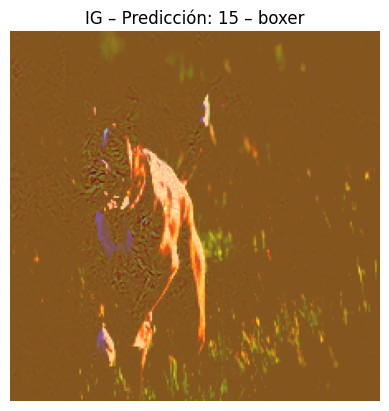

In [4]:
# Ejemplo de uso:
explain_image(r"data\images\boxer\boxer_4.jpg")

---
# Conclusion
Con Integrated Gradients se genera, para cada píxel de la imagen, una estimación de la contribución individual de ese píxel al incremento (o decremento) de la puntuación predicha por el modelo para la clase de interés. En la visualización resultante:

Imagen de fondo
Se muestra la imagen original, tal como era procesada por el modelo (escalada, normalizada y convertida a tensor).

Mapa de atribución superpuesto
Sobre la imagen de fondo se dibuja un mapa de calor, cuyos valores han sido normalizados en el rango 
0
,
1
0,1:

Rojo muy intenso indica los píxeles cuya contribución positiva al score de la clase elegida es máxima.

Tonos más oscuros (hacia marrón o anaranjado tenue) reflejan contribuciones menores e incluso cercanas a cero.

En el caso concreto de la salida titulada “IG para clase 22”, las regiones con mayor intensidad de color coinciden con:

Área facial y hocico (ojos, nariz y boca), cuyas texturas y formas resultan decisivas para que el modelo reconozca la raza o especie correspondiente a la etiqueta 22.

Contorno del pelaje, que aporta información crítica sobre la silueta y el perfil del animal.

Estas zonas sobreimpresas constituyen la explicación visual: muestran de manera explícita qué partes de la imagen influyeron con mayor peso en la decisión final del modelo.